## 寫在最前面：如果中途發生了原因不明的crush，請改用py檔偵測，這樣才能看到完整的錯誤訊息。

## 讀取模組、建立函數、建立參數

In [2]:
##### Module Import

### Common Module

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

### Tensorflow Module

import tensorflow as tf
from keras.datasets import mnist
from keras.utils    import np_utils
from keras.models   import Sequential
from keras.layers   import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [3]:
##### Functions

### for plotting train history
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()

In [4]:
##### Parameter

### VRAM Usage: Input VRAM memory usage limitation in MB
mem_limit = 1024 * 4

## 檢查tensorflow是否有抓到GPU，顯示0表示沒抓到。

In [5]:
##### Check if GPU detected

gpus = tf.config.list_physical_devices('GPU')
if gpus:  
    try: # Restrict TensorFlow to only allocate "mem_limit" MB of memory on the first GPU
        tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=mem_limit)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPU(s) detected.')
        print(f'{len(logical_gpus)} Logical GPU(s) detected.')
    except RuntimeError as e: # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPU(s) detected.
1 Logical GPU(s) detected.


## 讀取資料、前處理

In [6]:
##### Load MNIST dataset from internet via mnist.load_data()

(x_Train, y_Train), (x_Test, y_Test) = mnist.load_data()

In [7]:
##### Data Pre-processing

# Reshape
x_Train4D = x_Train.reshape(x_Train.shape[0], 28, 28, 1).astype('float32')
x_Test4D  = x_Test.reshape(x_Test.shape[0], 28, 28, 1).astype('float32')

# Normalization
x_Train4D_normalize = x_Train4D / 255
x_Test4D_normalize  = x_Test4D / 255

# Change to One-Hot format
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot  = np_utils.to_categorical(y_Test)

## 建立模型、執行訓練

In [8]:
##### Create Model

model = Sequential(name='MNIST_GPU_test')

model.add(Conv2D(filters=16,
                 kernel_size=(5, 5),
                 padding='same',
                 input_shape=(28, 28, 1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=36,
                kernel_size=(5, 5),
                padding='same',
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [9]:
##### Print model summary

print(model.summary())

Model: "MNIST_GPU_test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 36)        14436     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 36)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 36)          0         
                                                                 
 flatten (Flatten)           (None, 1764)           

### 檢查是否有使用GPU計算：
### 執行下方model.fit時，GPU中的Cuda選項有在動才是真的在用GPU計算。


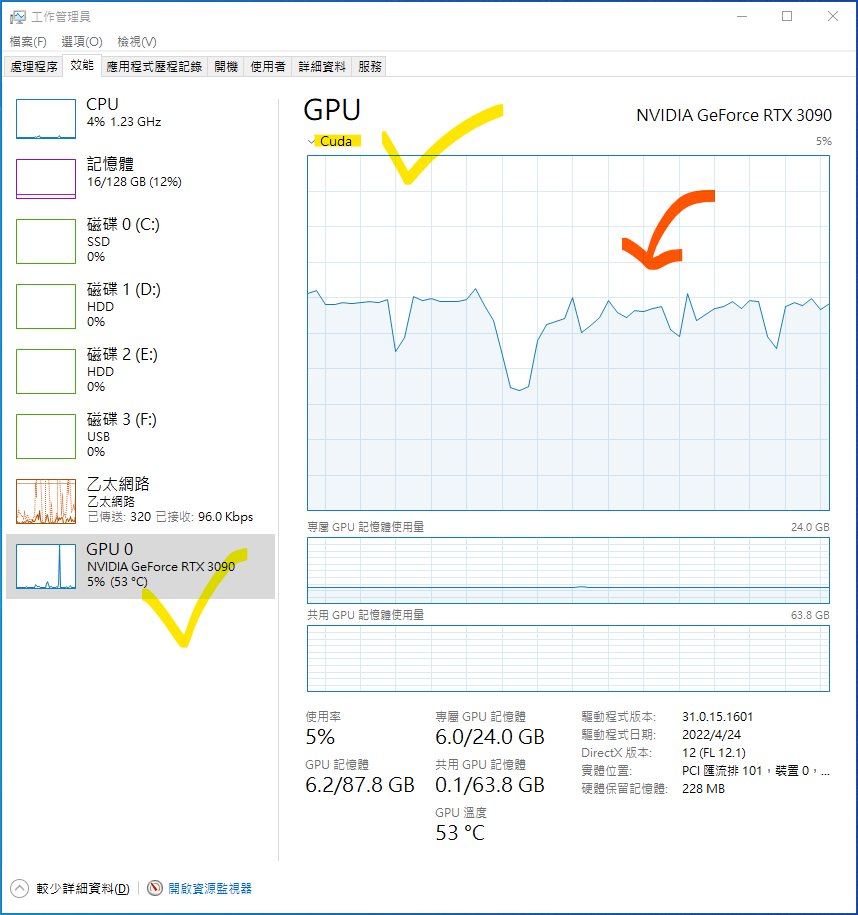

In [10]:
##### Model compiling

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

train_history = model.fit(x=x_Train4D_normalize,
                          y=y_TrainOneHot,
                          validation_split=0.2,
                          epochs=10,
                          batch_size=30,
                          verbose=2)

Epoch 1/10
1600/1600 - 11s - loss: 0.2333 - accuracy: 0.9278 - val_loss: 0.0594 - val_accuracy: 0.9807 - 11s/epoch - 7ms/step
Epoch 2/10
1600/1600 - 7s - loss: 0.0906 - accuracy: 0.9729 - val_loss: 0.0409 - val_accuracy: 0.9878 - 7s/epoch - 4ms/step
Epoch 3/10
1600/1600 - 7s - loss: 0.0653 - accuracy: 0.9808 - val_loss: 0.0401 - val_accuracy: 0.9881 - 7s/epoch - 4ms/step
Epoch 4/10
1600/1600 - 7s - loss: 0.0568 - accuracy: 0.9830 - val_loss: 0.0515 - val_accuracy: 0.9863 - 7s/epoch - 4ms/step
Epoch 5/10
1600/1600 - 7s - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.0321 - val_accuracy: 0.9912 - 7s/epoch - 4ms/step
Epoch 6/10
1600/1600 - 7s - loss: 0.0413 - accuracy: 0.9871 - val_loss: 0.0387 - val_accuracy: 0.9904 - 7s/epoch - 4ms/step
Epoch 7/10
1600/1600 - 7s - loss: 0.0392 - accuracy: 0.9880 - val_loss: 0.0305 - val_accuracy: 0.9916 - 7s/epoch - 4ms/step
Epoch 8/10
1600/1600 - 7s - loss: 0.0363 - accuracy: 0.9884 - val_loss: 0.0406 - val_accuracy: 0.9897 - 7s/epoch - 4ms/step
Epoch 

## 訓練結果

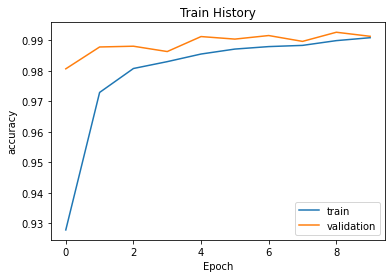

In [11]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

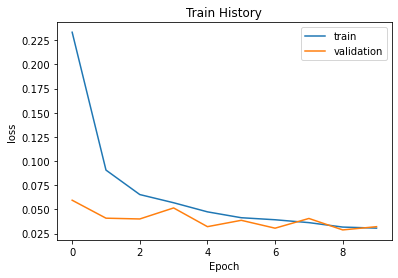

In [12]:
show_train_history(train_history, 'loss', 'val_loss')

In [13]:
##### Test values

loss_test, matrices_test = model.evaluate(x_Test4D_normalize, y_TestOneHot)
print(f'Loss value of test: {loss_test}')
print(f'Matrices value of test: {matrices_test}')

313/313 [==============================] - 2s 4ms/step - loss: 0.0244 - accuracy: 0.9933
Loss value of test: 0.024394158273935318
Matrices value of test: 0.9933000206947327


In [14]:
##### Get prediction of x_Test

prediction_mx = model.predict(x_Test4D_normalize)
classes       = np.argmax(prediction_mx, axis=1)

print(f'First 10 prediction: {classes[:10]}')

First 10 prediction: [7 2 1 0 4 1 4 9 5 9]


In [15]:
##### Confusion Matrix

print(pd.crosstab(y_Test, classes, rownames=['label'], colnames=['predict']))

predict    0     1     2     3    4    5    6     7    8    9
label                                                        
0        972     1     0     0    1    0    4     1    1    0
1          0  1135     0     0    0    0    0     0    0    0
2          2     2  1026     0    0    0    0     2    0    0
3          0     0     1  1009    0    0    0     0    0    0
4          0     0     0     0  979    0    1     0    0    2
5          1     0     0     5    0  884    1     0    0    1
6          2     2     0     0    1    0  952     0    1    0
7          0     4     3     1    0    0    0  1018    0    2
8          1     1     0     2    0    1    0     0  964    5
9          0     0     0     0   12    1    0     2    0  994


## 結束